   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

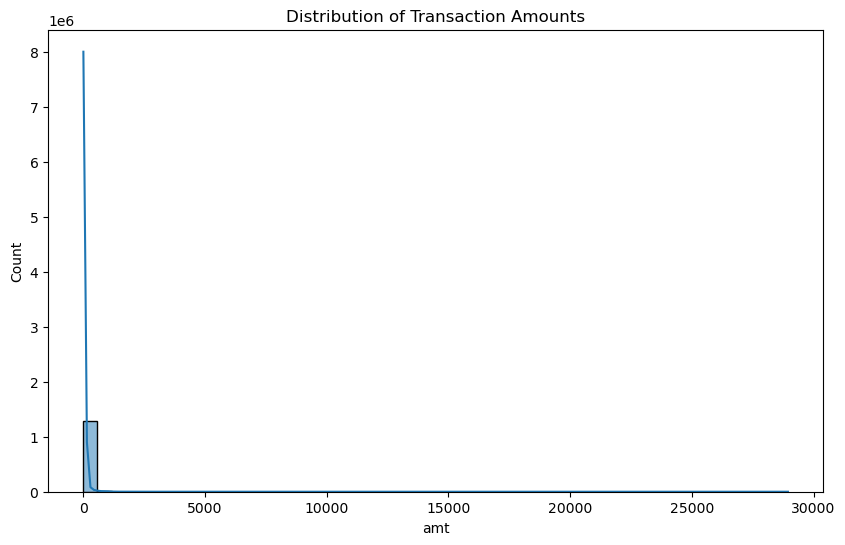

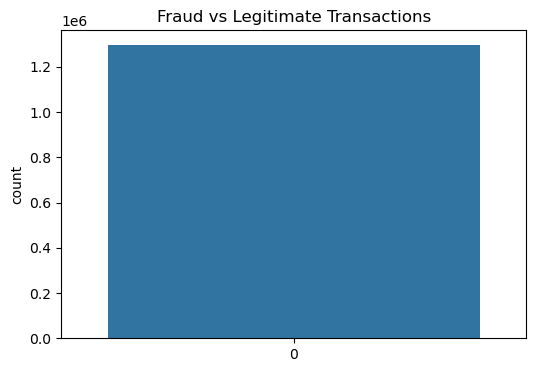

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('Dataset/fraudTrain.csv')

# Display the first few rows
print(data.head())

# Get summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['amt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Distribution of fraud vs. legitimate transactions
plt.figure(figsize=(6, 4))
sns.countplot(data['is_fraud'])
plt.title('Fraud vs Legitimate Transactions')
plt.show()


In [2]:
# Drop any rows with missing values (if applicable)
data_cleaned = data.dropna()

# Convert the transaction date to datetime for time-based analysis
data_cleaned['trans_date_trans_time'] = pd.to_datetime(data_cleaned['trans_date_trans_time'])

# Extract useful features from datetime (hour, day, month, year)
data_cleaned['hour'] = data_cleaned['trans_date_trans_time'].dt.hour
data_cleaned['day'] = data_cleaned['trans_date_trans_time'].dt.day
data_cleaned['month'] = data_cleaned['trans_date_trans_time'].dt.month
data_cleaned['year'] = data_cleaned['trans_date_trans_time'].dt.year

# Convert categorical columns like merchant and category into dummy/one-hot encoded columns
data_cleaned = pd.get_dummies(data_cleaned, columns=['merchant', 'category'], drop_first=True)

# Drop unnecessary columns (e.g., customer names)
data_cleaned = data_cleaned.drop(['first', 'last', 'street', 'city', 'state', 'job', 'dob'], axis=1)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Drop the 'trans_date_trans_time' column after extracting useful features
data_cleaned['hour'] = data_cleaned['trans_date_trans_time'].dt.hour
data_cleaned['day'] = data_cleaned['trans_date_trans_time'].dt.day
data_cleaned['month'] = data_cleaned['trans_date_trans_time'].dt.month
data_cleaned['year'] = data_cleaned['trans_date_trans_time'].dt.year

# Drop the original 'trans_date_trans_time' column
data_cleaned = data_cleaned.drop(['trans_date_trans_time'], axis=1)
data_cleaned = data_cleaned.drop(['trans_num'], axis=1)
data_cleaned = data_cleaned.drop(['gender'], axis=1)

# Define the feature set (X) and the target (y)
X = data_cleaned.drop(['is_fraud'], axis=1)
y = data_cleaned['is_fraud']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data (helps with convergence in some algorithms)
scaler = StandardScaler()

# Fit and transform the numeric columns only (assuming all features are numeric except categorical ones)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386718
           1       0.97      0.55      0.70      2285

    accuracy                           1.00    389003
   macro avg       0.99      0.78      0.85    389003
weighted avg       1.00      1.00      1.00    389003

Confusion Matrix:
 [[386683     35]
 [  1024   1261]]
AUC-ROC: 0.9803644699489434


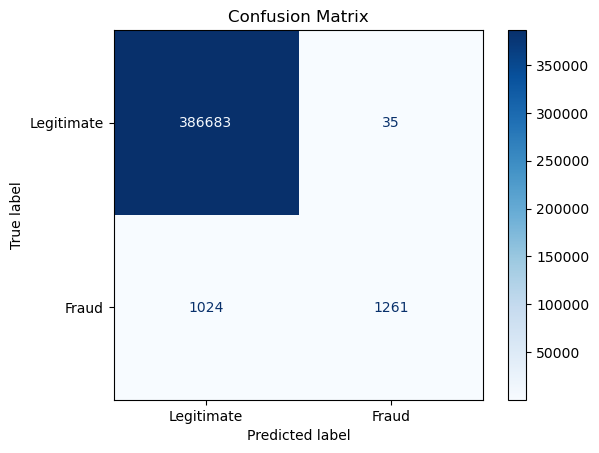

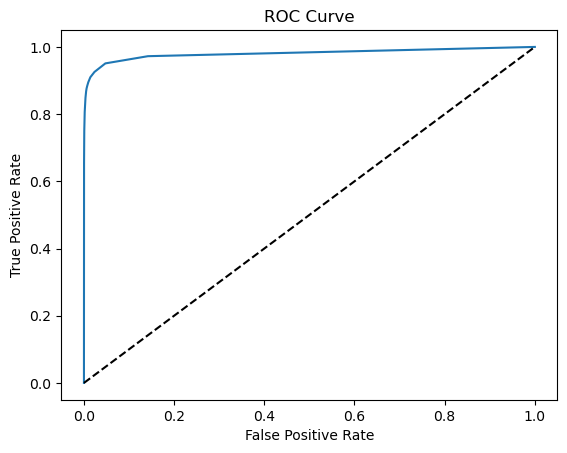

In [5]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Legitimate', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [7]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the results DataFrame
print(results_df.head(10))

         Actual  Predicted
1045211       0          0
547406        0          0
110142        0          0
1285953       0          0
271705        0          0
391181        0          0
962652        0          0
974821        0          0
127056        0          0
1122630       0          0
